In [1]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
#Loading and cleaning data
df = pd.read_csv("C:/Users/Administrator/Downloads/archive (1)/DATASET.csv")
df.dropna(subset=['Review'], inplace=True)
df.reset_index(drop=True, inplace=True)

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['cleaned_review'] = df['Review'].apply(clean_text)
df.head()



,Review,label,cleaned_review
0,"Great music service, the audio is high quality...",POSITIVE,great music service the audio is high quality ...
1,Please ignore previous negative rating. This a...,POSITIVE,please ignore previous negative rating this ap...
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE,this popup get the best spotify experience on ...
3,Really buggy and terrible to use as of recently,NEGATIVE,really buggy and terrible to use as of recently
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE,dear spotify why do i get songs that i didnt p...


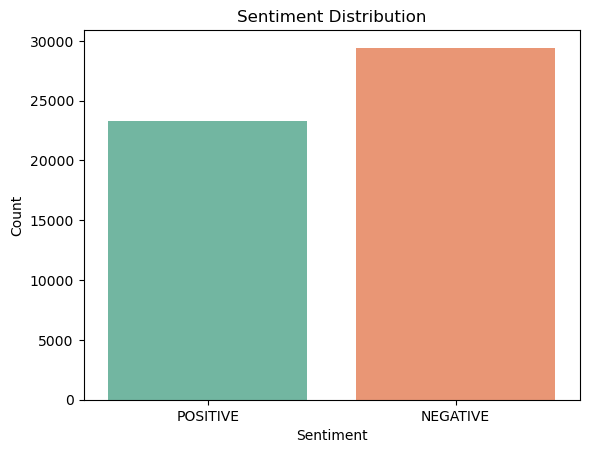

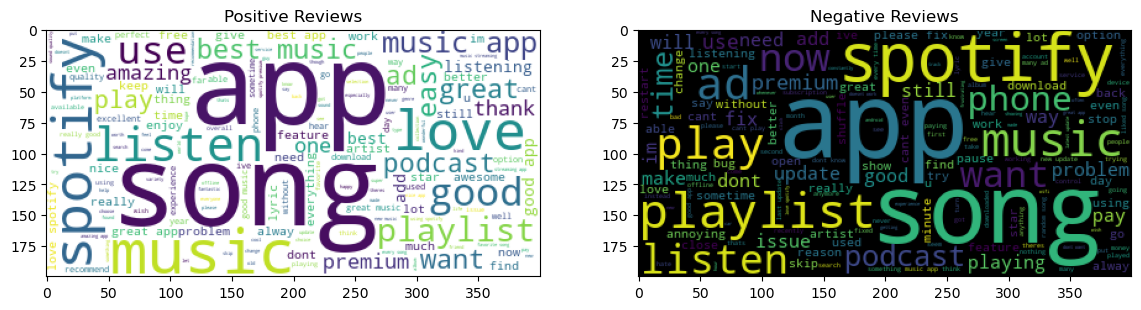

In [7]:
# 3.Sentiments visualizatio
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# WordClouds
positive_text = " ".join(df[df['label'] == 'POSITIVE']['cleaned_review'])
negative_text = " ".join(df[df['label'] == 'NEGATIVE']['cleaned_review'])

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color='white').generate(positive_text))
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color='black').generate(negative_text))
plt.title("Negative Reviews")
plt.show()


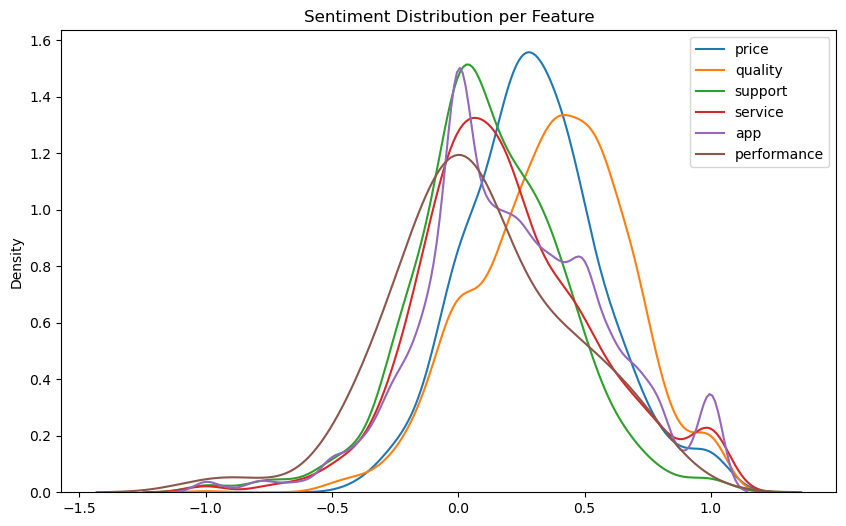

Avg Sentiment for 'price': 0.3 | Count: 364
Avg Sentiment for 'quality': 0.37 | Count: 1440
Avg Sentiment for 'support': 0.12 | Count: 598
Avg Sentiment for 'service': 0.19 | Count: 1712
Avg Sentiment for 'app': 0.22 | Count: 25370
Avg Sentiment for 'performance': 0.09 | Count: 89


In [8]:
# 4. SENTIMENT & FEATURE FOCUS (Bargaining Power of Buyers)
features = ['price', 'quality', 'support', 'service', 'app', 'performance']

def feature_sentiment(feature):
    results = []
    for review in df['cleaned_review']:
        if feature in review:
            polarity = TextBlob(review).sentiment.polarity
            results.append(polarity)
    return results

feature_sentiments = {feat: feature_sentiment(feat) for feat in features}

plt.figure(figsize=(10,6))
for feat, sentiments in feature_sentiments.items():
    sns.kdeplot(sentiments, label=feat)
plt.title("Sentiment Distribution per Feature")
plt.legend()
plt.show()

for feat, sentiments in feature_sentiments.items():
    avg_sent = np.mean(sentiments) if sentiments else 0
    print(f"Avg Sentiment for '{feat}': {round(avg_sent, 2)} | Count: {len(sentiments)}")


In [12]:
# 5. TOPIC MODELING
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_for_lda(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 3]
    return ' '.join(tokens)

df['lda_text'] = df['cleaned_review'].apply(preprocess_for_lda)

vectorizer = CountVectorizer(max_df=0.95, min_df=5)
doc_term_matrix = vectorizer.fit_transform(df['lda_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)



Topic #1:
work | premium | time | spotify | even | cant | downloaded | phone | offline | keep

Topic #2:
music | spotify | love | good | great | best | listen | like | song | listening

Topic #3:
spotify | star | would | like | lyric | please | dont | feature | give | option

Topic #4:
playing | stop | music | update | play | pause | spotify | keep | control | randomly

Topic #5:
song | play | playlist | listen | cant | want | like | dont | even | skip
